In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.linalg import expm, logm

from edesign import *
from utility import *
from models import *
from edesign import *
from display import *

#setup autoreload
%load_ext autoreload
%autoreload 2

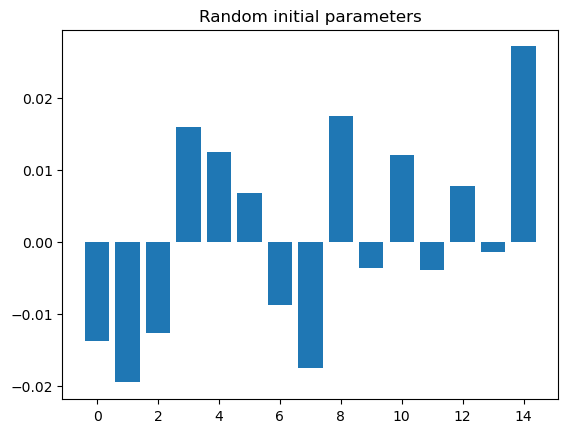

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
x = 0.01*np.random.randn(15)
plt.bar(range(15), x)
plt.title('Random initial parameters')
plt.show()
plt.figure()

In [3]:
def make_fibonacci_sequence(n):
    a = 1
    b = 1
    sequence = [a,b]
    for i in range(n-2):
        c = a+b
        sequence.append(c)
        a = b
        b = c
    return sequence[1:]

In [4]:
optimal_germs = [
    ['X1', 'X1', 'Y2', 'CZ'],
    ['Z1', 'Z1', 'Z1', 'Z2', 'CZ'],
    ['X1', 'Y1', 'Y1', 'Z1', 'CZ'],
    ['X1', 'X1', 'X1', 'Z1', 'X2', 'X2', 'X2', 'Z2', 'CZ'],
    ['Z1', 'Z1', 'X2', 'Z2', 'CZ'],
]
depths = make_fibonacci_sequence(21)
print(depths)

edesign = RPEDesign(UnitaryGateSetModel_CZOnly(), optimal_germs, depths)

[1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946]


In [5]:
signal = edesign.signal(optimal_germs[0], x, (0, 1))
target_signal = edesign.target_signal(optimal_germs[0], (0, 1))

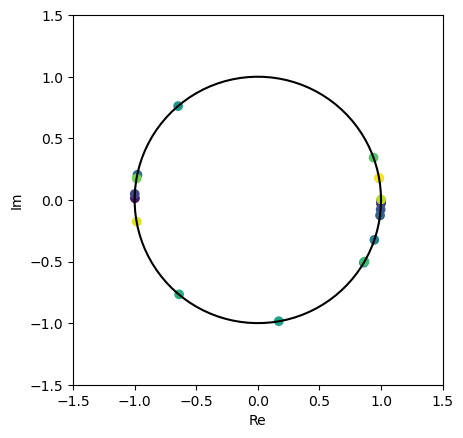

<Figure size 640x480 with 0 Axes>

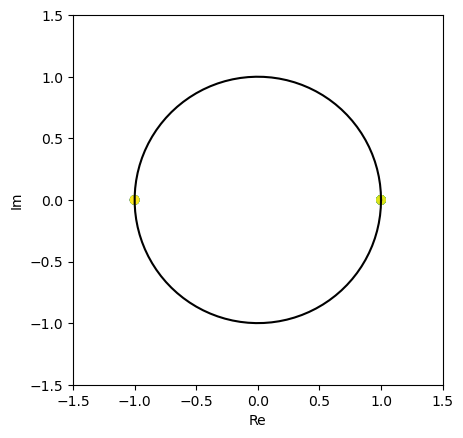

In [6]:
plot_complex_signal_in_unit_circle(signal)
plt.figure()
plot_complex_signal_in_unit_circle(target_signal)

# Naive optimization

In [7]:
def make_signal_dict(x, edesign, subspaces):
    germs = edesign.germs
    signals = {tuple(germ): {} for germ in germs}
    for germ in germs:
        for subspace in subspaces:
            signal = edesign.signal(germ, x, subspace)
            signals[tuple(germ)][subspace] = signal
    return signals

In [8]:
subspaces = [(0, 1), (1, 2), (2, 3)]
make_signal_dict(x, edesign, subspaces)

{('X1',
  'X1',
  'Y2',
  'CZ'): {(0,
   1): array([ 0.99997663-0.00574616j, -0.9976868 +0.01357359j,
          0.99983091-0.01746182j,  0.99954466-0.02976013j,
         -0.99883786+0.04804482j,  0.99694879-0.0777217j ,
          0.99204896-0.12550268j, -0.97708298+0.20428706j,
          0.94587637-0.32395087j,  0.86033268-0.5090405j ,
         -0.64696005+0.76175704j,  0.16987159-0.98426883j,
         -0.63898479-0.76628978j,  0.86548777-0.50049288j,
          0.9392737 +0.34353154j, -0.9837014 +0.17435804j,
          0.9844965 +0.17582528j,  0.99999159+0.00331871j,
         -0.9831824 -0.17661893j,  0.98370535+0.17990137j]), (1,
   2): array([ 0.0084005 +0.99947161j,  0.99952895-0.01697486j,
         -0.02503244-0.99945653j,  0.04182404+0.99862173j,
         -0.99776273+0.0668227j ,  0.10849341+0.99357183j,
          0.17467749+0.98407606j,  0.95951898-0.28068937j,
         -0.44367006-0.89569128j,  0.67718497+0.73497429j,
         -0.35839862+0.93314842j,  0.92923593-0.36890316j,
  

In [9]:
from scipy.optimize import minimize

def complex_distance(c1, c2):
    return np.abs(c1 - c2)**2

def cost_function(estimate, signal_dict, edesign, subspaces):
    estimate_signal_dict = make_signal_dict(estimate, edesign, subspaces)
    cost = 0
    for germ in signal_dict.keys():
        for subspace in subspaces:
            signal = signal_dict[germ][subspace]
            estimate_signal = estimate_signal_dict[germ][subspace]
            cost += complex_distance(signal, estimate_signal)
    return np.linalg.norm(cost)

def find_optimal_estimate(signal_dict, edesign, subspaces, x0=np.zeros(15), epsilon = 0.5):
    # make bounds from -epsilon to epsilon
    cost = lambda x: cost_function(x, signal_dict, edesign, subspaces)
    
    bounds = [(-epsilon, epsilon) for _ in range(15)]
    result = minimize(cost, x0, bounds=bounds)
    return result.x

In [10]:
cost_function(x, make_signal_dict(x, edesign, subspaces), edesign, subspaces)

0.0

In [11]:
find_optimal_estimate(make_signal_dict(x, edesign, subspaces), edesign, subspaces)

KeyboardInterrupt: 

# Residual angle growth

In [12]:
import math

def rectify_angle_sequence(angles):
  """
  Rectifies a monotonic sequence of angles between -pi and pi to handle 
  discontinuities caused by wrapping around.

  Args:
    angles: A list of angles in radians.

  Returns:
    A new list of angles with discontinuities rectified.
  """
  rectified_angles = [angles[0]]  # Initialize with the first angle
  for i in range(1, len(angles)):
    diff = angles[i] - rectified_angles[i-1] 
    if diff > math.pi:  # Jump from near pi to -pi
      rectified_angles.append(angles[i] - 2*math.pi)
    elif diff < -math.pi:  # Jump from near -pi to pi
      rectified_angles.append(angles[i] + 2*math.pi)
    else:
      rectified_angles.append(angles[i])
  return np.array(rectified_angles)



In [13]:
def calc_residual_phase(signal, target_signal, depths):
    residual_signal = signal*np.conj(target_signal)
    residual_log = np.log(residual_signal)
    residual_angles = np.imag(residual_log)/depths
    recitified_residual_angles = np.unwrap(residual_angles)
    return recitified_residual_angles

def make_residual_phase_plot(residual_phase, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(residual_phase)
    ax.plot(np.mean(residual_phase)*np.ones(len(residual_phase)), 'r--')
    if title is not None:
        ax.set_title(title)
    return ax


In [14]:
signal = edesign.signal(optimal_germs[0], x, (0, 1))
target_signal = edesign.target_signal(optimal_germs[0], (0, 1))

In [15]:
residual_signal = signal*np.conj(target_signal)

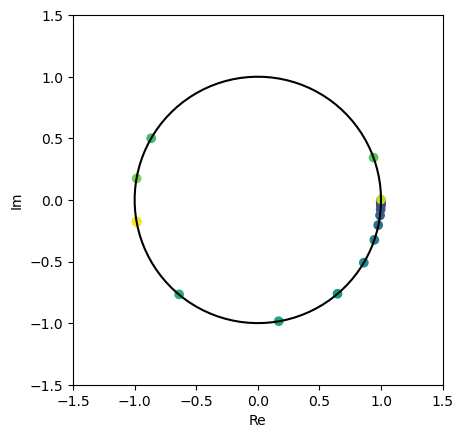

In [16]:
plot_complex_signal_in_unit_circle(residual_signal)

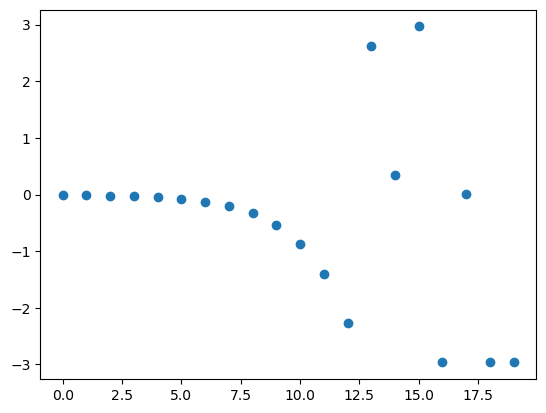

In [17]:
residual_log = np.log(residual_signal)
residual_angles = np.imag(residual_log)
plt.plot(residual_angles, 'o')

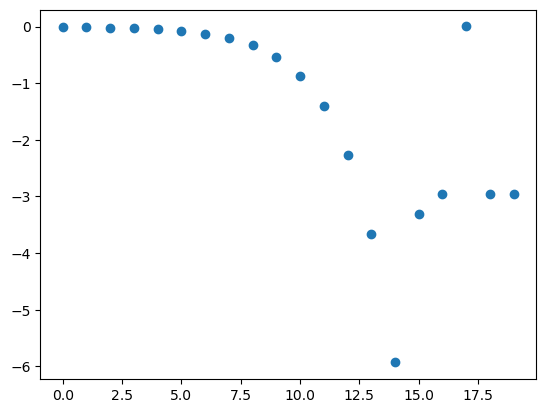

In [18]:
plt.plot(rectify_angle_sequence(residual_angles), 'o')

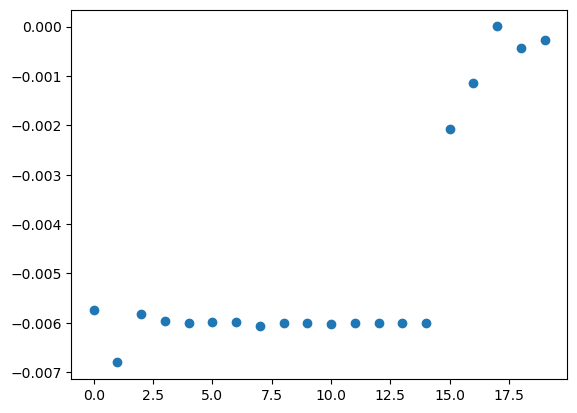

In [19]:
plt.plot(rectify_angle_sequence(residual_angles)/depths, 'o')

<Axes: >

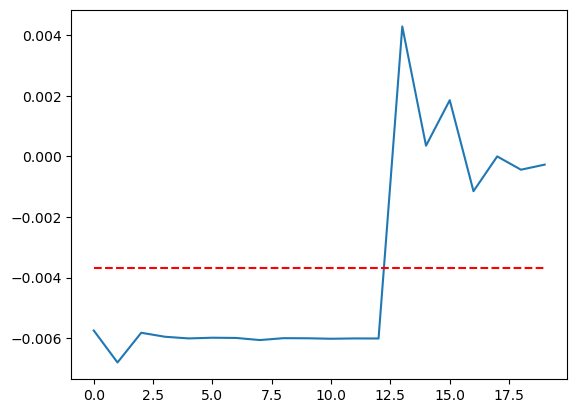

In [20]:
residual_phase = calc_residual_phase(signal, target_signal, depths)
make_residual_phase_plot(residual_phase)

# estimate and plot the residual phase of all experiments


In [21]:
optimal_germs = [
    ['X1', 'X1', 'Y2', 'CZ'],
    ['Z1', 'Z1', 'Z1', 'Z2', 'CZ'],
    ['X1', 'Y1', 'Y1', 'Z1', 'CZ'],
    ['X1', 'X1', 'X1', 'Z1', 'X2', 'X2', 'X2', 'Z2', 'CZ'],
    ['Z1', 'Z1', 'X2', 'Z2', 'CZ'],
]
depths = make_fibonacci_sequence(40)
print(depths)
subspaces = [(0, 1), (1, 2), (2, 3)]
edesign = RPEDesign(UnitaryGateSetModel_CZOnly(), optimal_germs, depths)
signal_dict = make_signal_dict(x, edesign, subspaces)
target_signal_dict = make_signal_dict(np.zeros(15), edesign, subspaces)

[1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040, 1346269, 2178309, 3524578, 5702887, 9227465, 14930352, 24157817, 39088169, 63245986, 102334155]


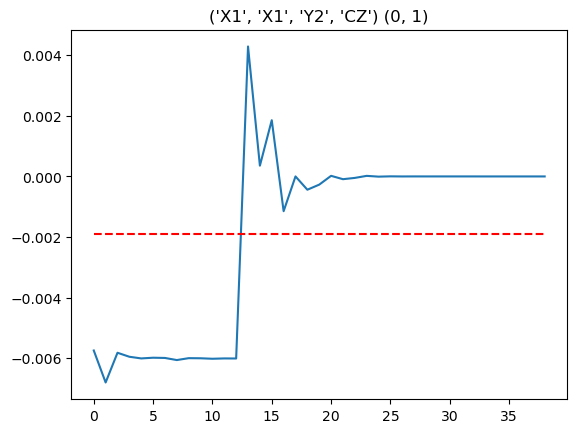

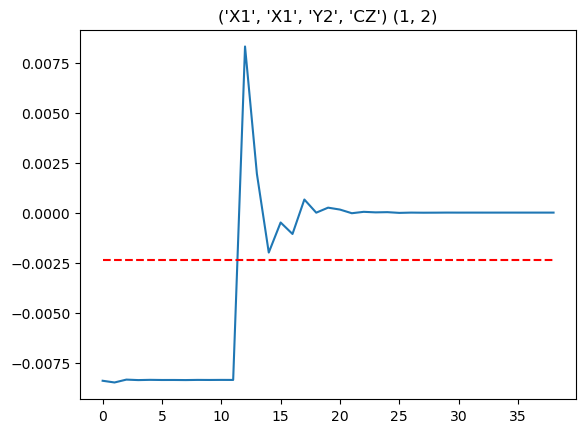

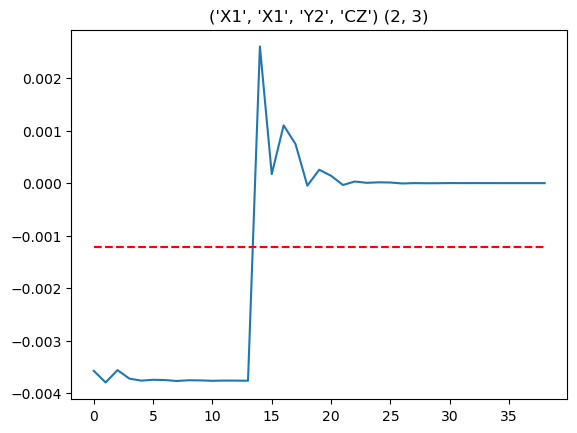

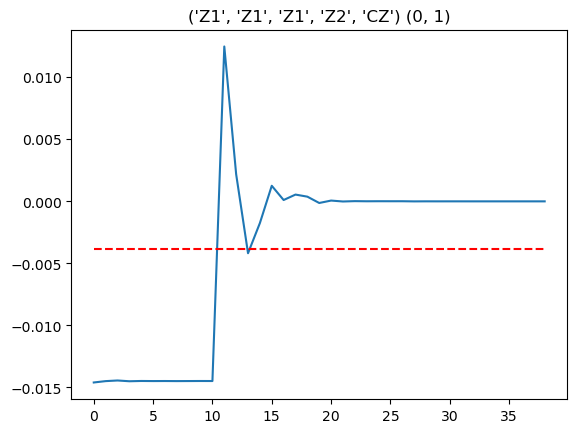

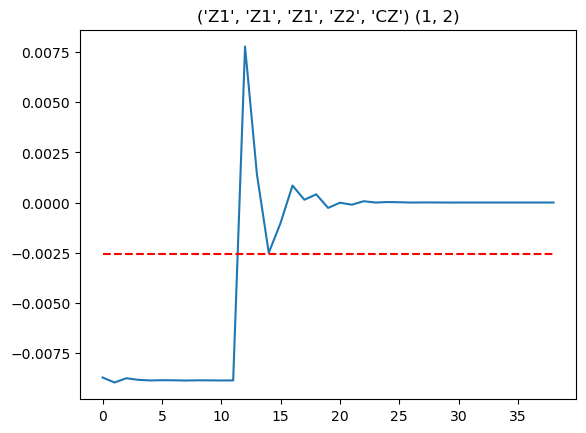

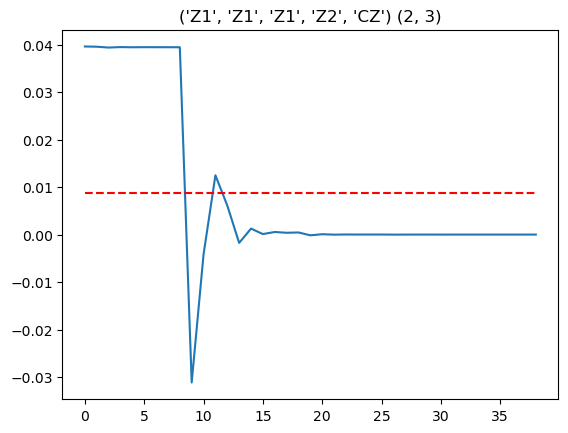

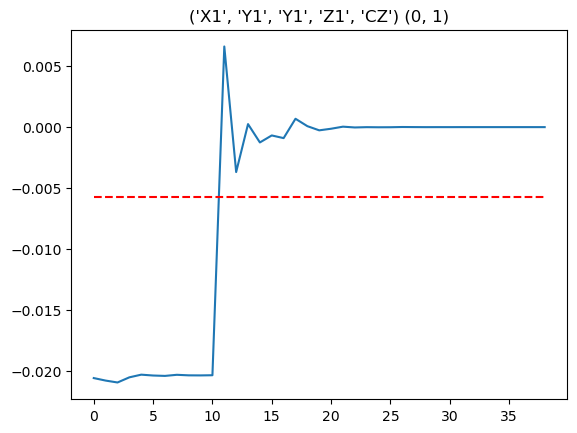

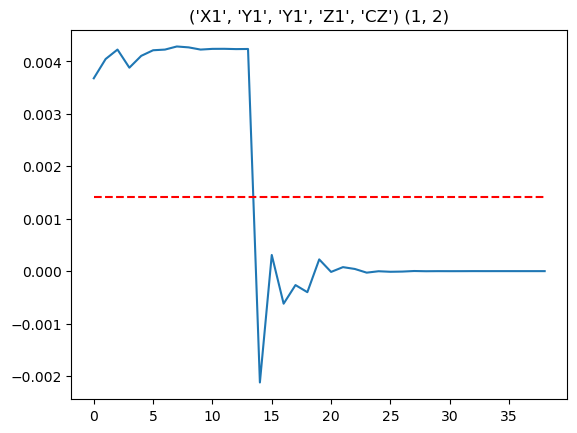

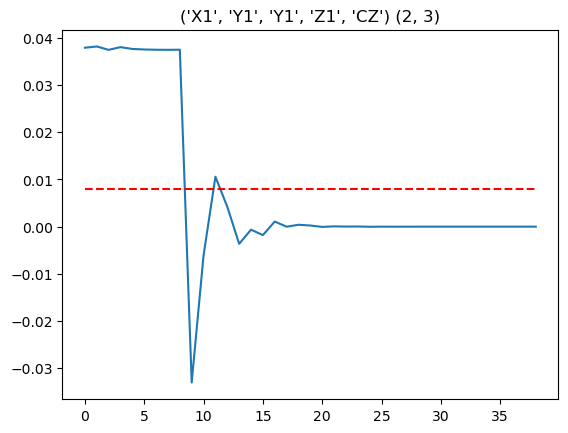

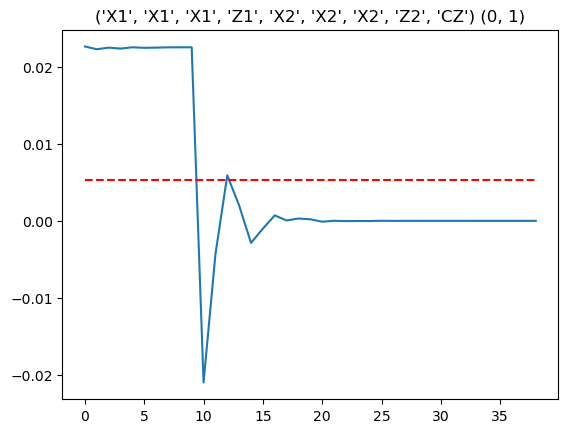

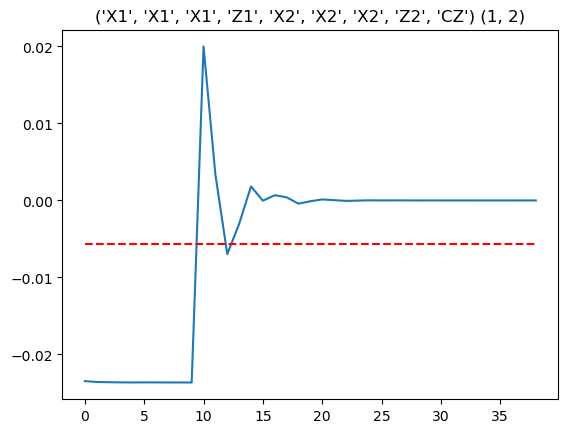

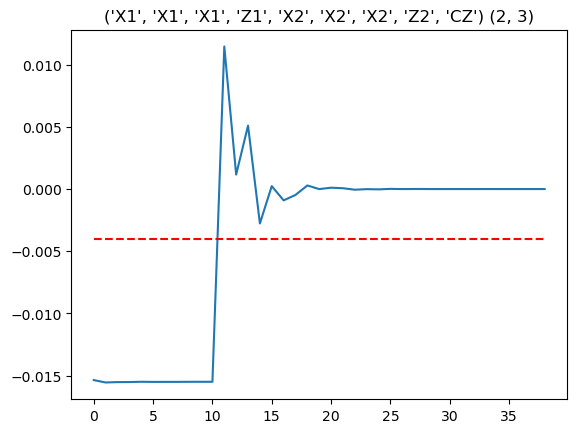

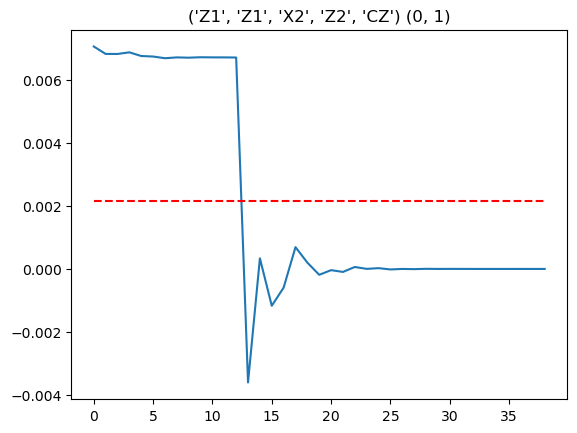

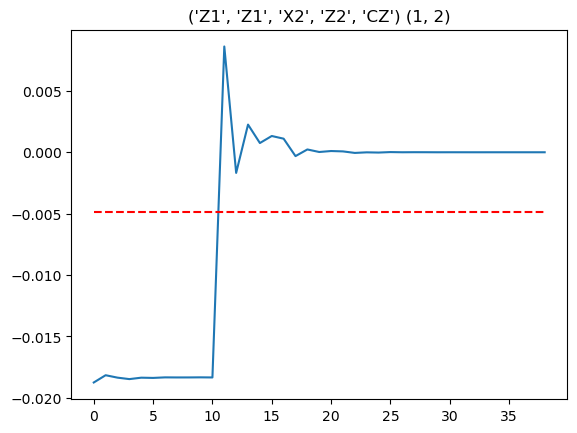

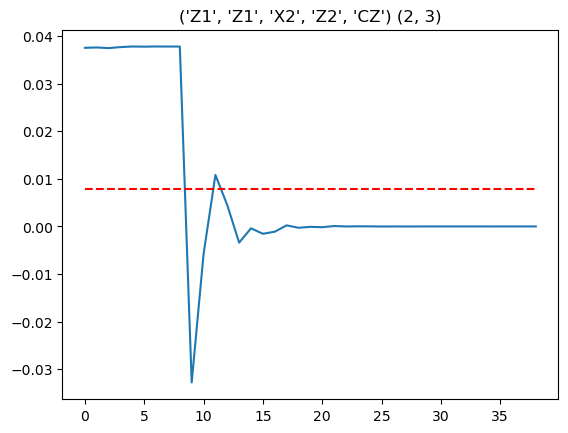

In [22]:
for germ in signal_dict.keys():
    for subspace in subspaces:
        signal = signal_dict[germ][subspace]
        target_signal = target_signal_dict[germ][subspace]
        residual_phase = calc_residual_phase(signal, target_signal, depths)
        make_residual_phase_plot(residual_phase, title=f'{germ} {subspace}')

# fit below divergence depth, and try the linear inversion

In [23]:
def plot_all_residual_phases(signal_dict, target_signal_dict, depths):
    for germ in signal_dict.keys():
        for subspace in subspaces:
            signal = signal_dict[germ][subspace]
            target_signal = target_signal_dict[germ][subspace]
            residual_phase = calc_residual_phase(signal, target_signal, depths)
            make_residual_phase_plot(residual_phase, title=f'{germ} {subspace}')


In [24]:
optimal_germs = [
    ['X1', 'X1', 'Y2', 'CZ'],
    ['Z1', 'Z1', 'Z1', 'Z2', 'CZ'],
    ['X1', 'Y1', 'Y1', 'Z1', 'CZ'],
    ['X1', 'X1', 'X1', 'Z1', 'X2', 'X2', 'X2', 'Z2', 'CZ'],
    ['Z1', 'Z1', 'X2', 'Z2', 'CZ'],
]
depths = make_fibonacci_sequence(10)
print(depths)
subspaces = [(0, 1), (1, 2), (2, 3)]
edesign = RPEDesign(UnitaryGateSetModel_CZOnly(), optimal_germs, depths)
signal_dict = make_signal_dict(x, edesign, subspaces)
target_signal_dict = make_signal_dict(np.zeros(15), edesign, subspaces)

[1, 2, 3, 5, 8, 13, 21, 34, 55]


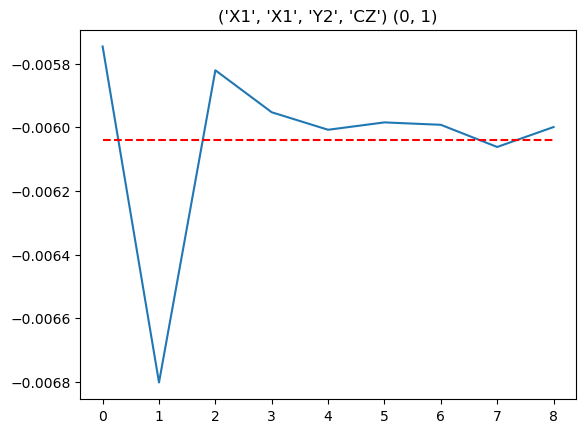

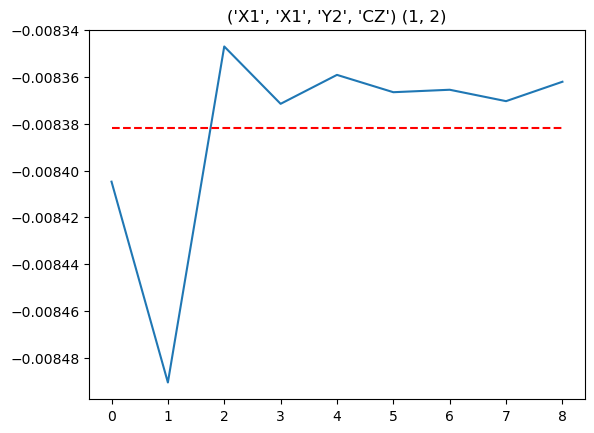

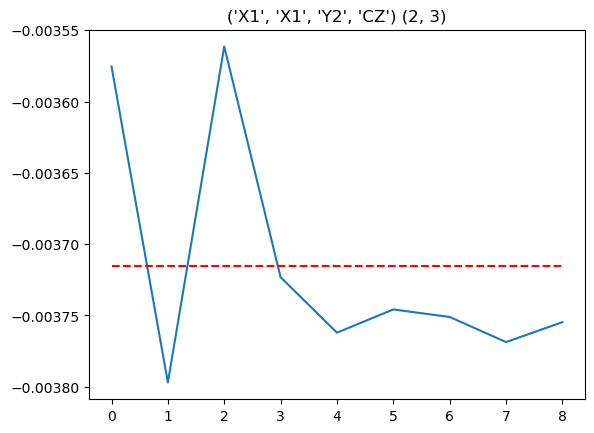

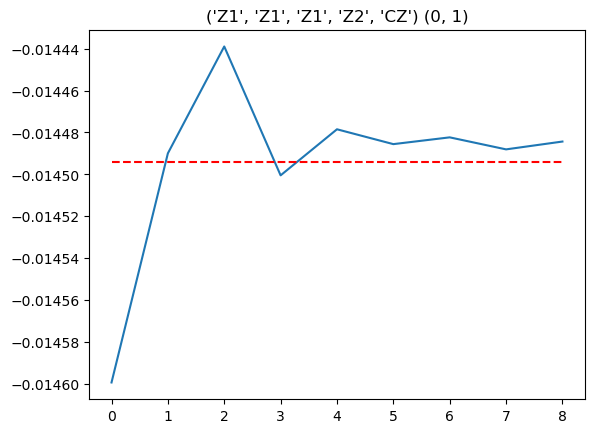

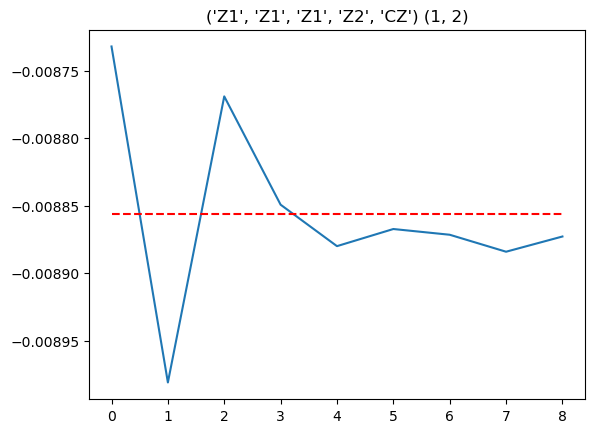

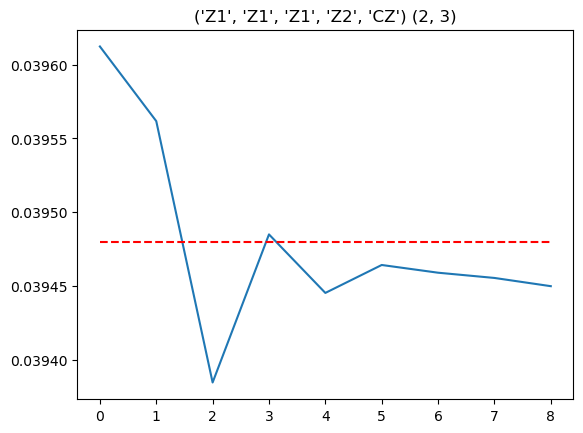

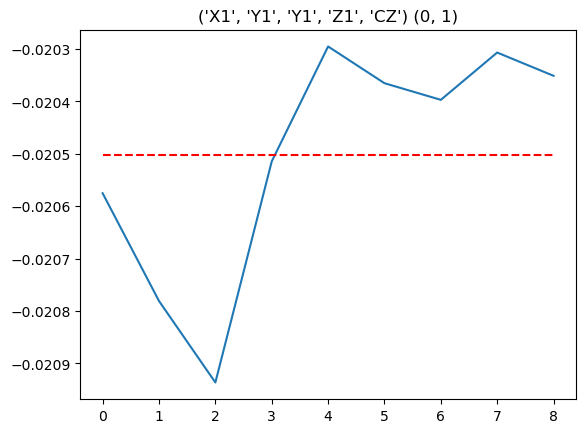

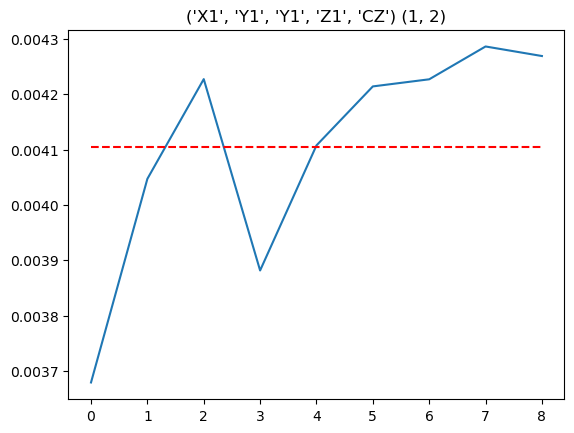

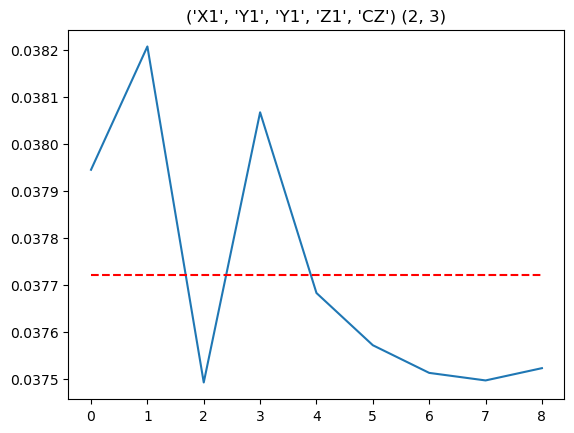

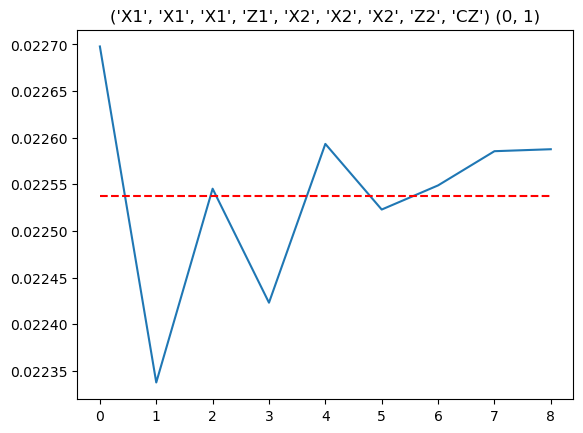

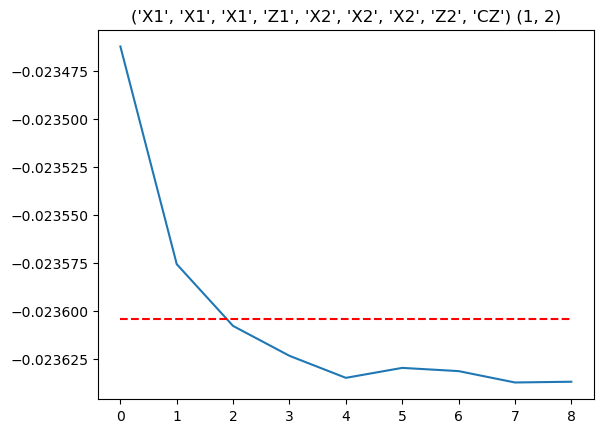

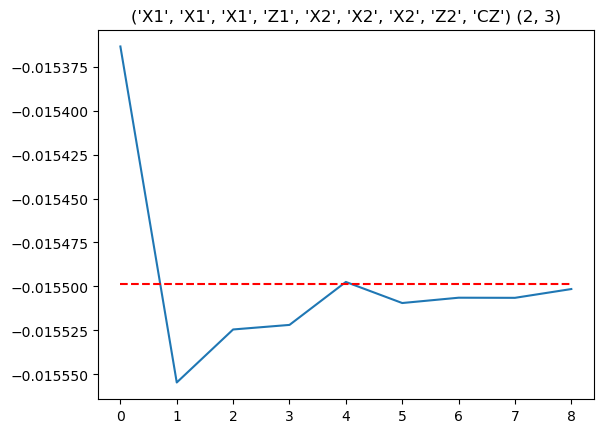

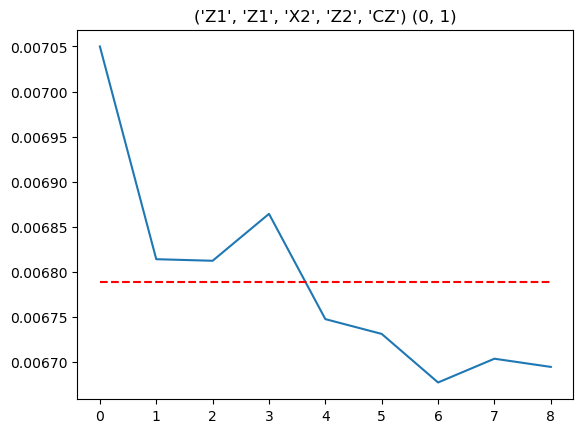

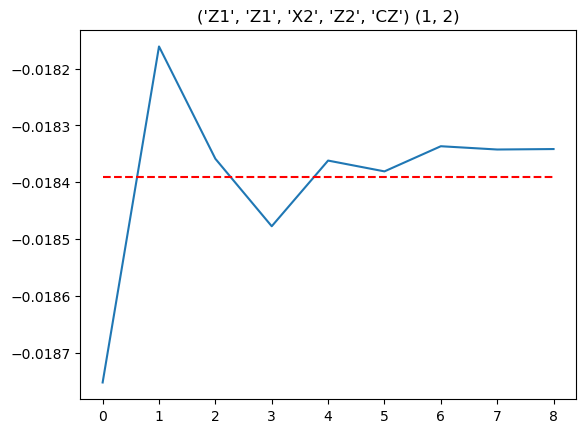

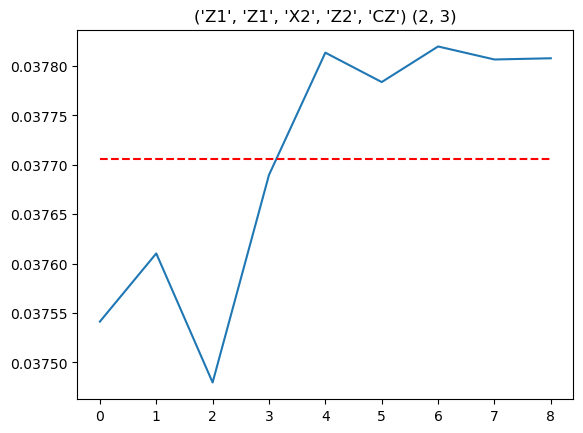

In [25]:
plot_all_residual_phases(signal_dict, target_signal_dict, depths)

In [26]:
def find_all_residual_phase_estimates(x, edesign, subspaces):
    phase_dict = {}
    for germ in edesign.germs:
        for subspace in subspaces:
            signal = edesign.signal(germ, x, subspace)
            target_signal = edesign.target_signal(germ, subspace)
            residual_phase = calc_residual_phase(signal, target_signal, edesign.depths)
            phase_estimate = np.mean(residual_phase)
            phase_dict[(tuple(germ), subspace)] = phase_estimate
    return phase_dict

In [27]:
cartan_basis = [
    np.diag([1, -1, 0, 0]),
    np.diag([0, 1, -1, 0]), 
    np.diag([0, 0, 1, -1]),
]


def calc_cartan_phases(U, basis=cartan_basis):
    log_U = logm(U)
    cartan_phases = np.array([ np.trace(log_U @ B) for B in basis])
    # check that the frame is imaginary
    assert np.allclose(np.real(cartan_phases), 0)
    return np.imag(cartan_phases)

def calc_cartan_jacobian(U, model, epsilon=1e-6):
    basis = model.cartan_basis
    num_params = model.num_params
    jacobian = np.zeros((len(basis), num_params))
    for i in range(num_params):
        X_i = model.lie_basis(i)
        U_plus = expm(1j*epsilon*X_i) @ U
        U_minus = expm(-1j*epsilon*X_i) @ U
        phases_plus = calc_cartan_phases(U_plus, basis)
        phases_minus = calc_cartan_phases(U_minus, basis)
        jacobian[:, i] = angular_difference(phases_plus, phases_minus)/(2*epsilon)
    return jacobian



In [28]:
subspaces = [(0, 1), (1, 2), (2, 3)]

subspace_to_cartan = {
    (0, 1): np.diag([1, -1, 0, 0]),
    (1, 2): np.diag([0, 1, -1, 0]),
    (2, 3): np.diag([0, 0, 1, -1]),
}

def calc_single_cartan_phase(U, B):
    log_U = logm(U)
    phase = np.trace(log_U @ B)
    assert np.allclose(np.real(phase), 0)
    return np.imag(phase)


def calc_cartan_jacobian_row(U, model, subspace, epsilon=1e-6):
    B = subspace_to_cartan[subspace]
    num_params = model.num_params
    jacobian = np.zeros(num_params)
    for i in range(num_params):
        X_i = model.lie_basis(i)
        U_plus = expm(1j*epsilon*X_i) @ U
        U_minus = expm(-1j*epsilon*X_i) @ U
        phases_plus = calc_single_cartan_phase(U_plus, B)
        phases_minus = calc_single_cartan_phase(U_minus, B)
        jacobian[i] = angular_difference(phases_plus, phases_minus)/(2*epsilon)
    return jacobian



def calc_target_model_frame(model, edesign, subspaces):
    frame_dict = {}
    for germ in edesign.germs:
        for subspace in subspaces:
            U = model.compile_unitary(germ, np.zeros(15))
            jac_row = calc_cartan_jacobian_row(U, edesign.model, subspace)
            frame_dict[(tuple(germ), subspace)] = jac_row
    return frame_dict
    


In [29]:
phase_dict = find_all_residual_phase_estimates(x, edesign, subspaces)

In [30]:
model = UnitaryGateSetModel_CZOnly()
frame_dict = calc_target_model_frame(model, edesign, subspaces)

In [31]:
frame_dict

{(('X1', 'X1', 'Y2', 'CZ'),
  (0,
   1)): array([ 1.57079533e+06,  8.88178420e-10,  1.57079533e+06, -1.11072074e+00,
         1.11072073e+00,  1.57079522e+06,  1.11072073e+00,  1.57079522e+06,
         1.57079522e+06,  1.57079633e+06,  1.57079522e+06,  4.44089210e-10,
        -1.57079533e+06,  0.00000000e+00,  1.57079533e+06]),
 (('X1', 'X1', 'Y2', 'CZ'),
  (1,
   2)): array([-7.85397663e+05, -2.22044605e-10, -7.85397663e+05,  1.66608110e+00,
        -2.77680184e+00,  7.85397608e+05, -5.55360367e-01,  7.85397608e+05,
        -7.85397608e+05, -7.85398163e+05, -7.85399829e+05, -2.22044605e-10,
         7.85397663e+05,  1.57079633e+00, -7.85397663e+05]),
 (('X1', 'X1', 'Y2', 'CZ'),
  (2,
   3)): array([ 1.57074354e-06, -4.44089210e-10, -1.57007740e-06,  1.11022302e-09,
         2.22144147e+00,  0.00000000e+00, -2.22144147e+00,  0.00000000e+00,
        -2.22144147e+00, -4.44089210e-10,  2.22144147e+00,  0.00000000e+00,
         1.57074354e-06, -3.14159265e+00,  1.57118762e-06]),
 (('Z1', '

In [32]:
# make a vector and a matrix by stacking the frames and the phases in the same ways
frame_matrix = np.vstack([frame_dict[key] for key in frame_dict.keys()])
phase_vector = np.array([phase_dict[key] for key in phase_dict.keys()])

In [33]:
x

array([-0.01375811, -0.01949848, -0.0126347 ,  0.01601184,  0.01244142,
        0.00685177, -0.00877642, -0.01755459,  0.01753275, -0.00367286,
        0.01210511, -0.0038636 ,  0.00778115, -0.00139616,  0.02714239])

In [34]:
phase_vector

array([-0.00604099, -0.0083819 , -0.00371549, -0.01449415, -0.00885636,
        0.0394797 , -0.02050256,  0.00410448,  0.03772256,  0.02253795,
       -0.02360442, -0.01549841,  0.00678852, -0.01839022,  0.03770583])

In [35]:
frame_matrix@phase_vector

array([ 1.59280398e+05, -1.11783476e+04, -5.25882997e-02, -6.79806897e-02,
        2.35658521e-02,  8.28426361e-02, -6.70582956e-02, -2.09133857e-02,
        8.19202421e-02, -4.43681628e-02, -3.34572172e-02,  2.84483755e-02,
       -7.64776443e-02,  4.34487105e-02,  5.15738740e-02])